# Solution to homework 5

Covers Lectures 16, 17, 21.

## Bayesian approach
### Calibrating the reaction rates kappa [0-4] in Catalytic Conversion of Nitrate to Nitrogen

In [1]:
# =====================
# LAOD REQUIRED MODULES
# =====================

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import pymc as pm
import pandas as pd
from ipywidgets import interactive
import scipy as scipy 

ImportError: No module named pandas

In [4]:
# ========================
# COMPUTER MODEL FUNCTIONS
# ========================

def rk45( f, y0, t, args=() ):
    """Fourth-order Runge-Kutta method with error estimate.

    USAGE:
        y = rk45(f, x0, t, args=())

    INPUT:
        f     - function of x and t equal to dx/dt.  x may be multivalued,
                in which case it should a list or a NumPy array.  In this
                case f must return a NumPy array with the same dimension
                as x.
        y0    - the initial condition(s).  Specifies the value of x when
                t = t[0].  Can be either a scalar or a list or NumPy array
                if a system of equations is being solved.
        t     - list or NumPy array of t values to compute solution at.
                t[0] is the the initial condition point, and the difference
                h=t[i+1]-t[i] determines the step size h.
        args  - any other parameters of the function f.

    OUTPUT:
        y     - NumPy array containing solution values corresponding to each
                entry in t array.  If a system is being solved, x will be
                an array of arrays.

    NOTES:
        This version is based on the algorithm presented in "Numerical
        Mathematics and Computing" 6th Edition, by Cheney and Kincaid,
        Brooks-Cole, 2008.
    """

    # Coefficients used to compute the independent variable argument of f

    c20  =   2.500000000000000e-01  #  1/4
    c30  =   3.750000000000000e-01  #  3/8
    c40  =   9.230769230769231e-01  #  12/13
    c50  =   1.000000000000000e+00  #  1
    c60  =   5.000000000000000e-01  #  1/2

    # Coefficients used to compute the dependent variable argument of f

    c21 =   2.500000000000000e-01  #  1/4
    c31 =   9.375000000000000e-02  #  3/32
    c32 =   2.812500000000000e-01  #  9/32
    c41 =   8.793809740555303e-01  #  1932/2197
    c42 =  -3.277196176604461e+00  # -7200/2197
    c43 =   3.320892125625853e+00  #  7296/2197
    c51 =   2.032407407407407e+00  #  439/216
    c52 =  -8.000000000000000e+00  # -8
    c53 =   7.173489278752436e+00  #  3680/513
    c54 =  -2.058966861598441e-01  # -845/4104
    c61 =  -2.962962962962963e-01  # -8/27
    c62 =   2.000000000000000e+00  #  2
    c63 =  -1.381676413255361e+00  # -3544/2565
    c64 =   4.529727095516569e-01  #  1859/4104
    c65 =  -2.750000000000000e-01  # -11/40

    # Coefficients used to compute 4th order RK estimate

    a1  =   1.157407407407407e-01  #  25/216
    a2  =   0.000000000000000e-00  #  0
    a3  =   5.489278752436647e-01  #  1408/2565
    a4  =   5.353313840155945e-01  #  2197/4104
    a5  =  -2.000000000000000e-01  # -1/5

    b1  =   1.185185185185185e-01  #  16.0/135.0
    b2  =   0.000000000000000e-00  #  0
    b3  =   5.189863547758284e-01  #  6656.0/12825.0
    b4  =   5.061314903420167e-01  #  28561.0/56430.0
    b5  =  -1.800000000000000e-01  # -9.0/50.0
    b6  =   3.636363636363636e-02  #  2.0/55.0

    n = len( t )
    y = np.array( [ y0 ] * n )
    for i in xrange( n - 1 ):
        h = t[i+1] - t[i]
        k1 = h * f( y[i], t[i], *args )
        k2 = h * f( y[i] + c21 * k1, t[i] + c20 * h, *args )
        k3 = h * f( y[i] + c31 * k1 + c32 * k2, t[i] + c30 * h, *args )
        # BUG: The ``-`` in the equation below should be a ``+``.
        k4 = h * f( y[i] + c41 * k1 + c42 * k2 + c43 * k3, t[i] + c40 * h, *args )
        k5 = h * f( y[i] + c51 * k1 + c52 * k2 + c53 * k3 + c54 * k4, \
                        t[i] + h, *args )
        k6 = h * f( \
            y[i] + c61 * k1 + c62 * k2 + c63 * k3 + c64 * k4 + c65 * k5, \
            t[i] + c60 * h, *args )

        y[i+1] = y[i] + a1 * k1 + a3 * k3 + a4 * k4 + a5 * k5
        y5 = y[i] + b1 * k1 + b3 * k3 + b4 * k4 + b5 * k5 + b6 * k6

    return y

def f_catalysis(y, t, kappa):
    rhs = np.zeros((6,))
    rhs[0] = -kappa[0] * y[0]
    rhs[1] = kappa[0] * y[0] - (kappa[1] + kappa[3] + kappa[4]) * y[1]
    rhs[2] = kappa[1] * y[1] - kappa[2] * y[2]
    rhs[3] = kappa[2] * y[2]
    rhs[4] = kappa[3] * y[1]
    rhs[5] = kappa[4] * y[1]
    return rhs

def comp_model(xi1, xi2, xi3, xi4, xi5):
    t = np.linspace(0, 180, 100)
    kappa = np.exp([xi1, xi2, xi3, xi4, xi5]) / 180.
    y = rk45(f_catalysis, (500., 0., 0., 0., 0., 0.), t, args=(kappa,))
    return np.array([y[-1,0],y[-1,1],y[-1,3],y[-1,4],y[-1,5]]).flatten(0)

# =====================
# AUXILIARY FUNCTIONS
# =====================

import numpy as np
from scipy.linalg import toeplitz
# from __future__ import division, absolute_import, print_function

def myacorr(x) :
    mean_x = x.mean()
    z = np.fft.fft( x-mean_x, int(2**np.ceil( np.log2(2*x.size) ))+1 )
    z = z.real**2 + z.imag**2
    z = np.fft.ifft( z ).real
    z = z[:x.size]
    z = z/z[0]
    return z

# from __future__ import division, absolute_import, print_function
from scipy.linalg import toeplitz

def iat(x):
    r"""Estimate the integrated autocorrelation time, :math:`\tau_{int}` of a
    time series.

    This method estimates the spectral density at zero frequency by fitting
    an AR(p) model, with p selected by AIC.

    Parameters
    ----------
    x : ndarray, shape=(n_samples, n_dims)
        The time series, with time along axis 0.

    References
    ----------
    .. [1] Plummer, M., Best, N., Cowles, K., and Vines, K. (2006). CODA:
        Convergence diagnosis and output analysis for MCMC. R News, 6(1):7-11.

    Returns
    -------
    tau_int : ndarray, shape=(n_dims,)
        The estimated integrated autocorrelation time of each dimension in
        ``x``, considered independently.
    """
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    process_var = np.var(x, axis=0, ddof=1)

    tau_int = np.zeros(x.shape[1])
    for j in range(x.shape[1]):
        # fit an AR(p) model, with p selected by AIC
        rho, sigma2 = yule_walker(x[:,j], order_max=10)
        # power spectral density at zero frequency
        spec0 = sigma2 / (1 - np.sum(rho))**2
        # divide by the variance
        tau_int[j] = spec0 / process_var[j]

    return tau_int

def yule_walker(X, aic=True, order_max=None, demean=True):
    """Estimate AR(p) parameters from a sequence X using Yule-Walker equation.

    Parameters
    ----------
    X : array-like
        1d array
    aic: bool
        If ``True``, then the Akaike Information Criterion is used to choose
        the order of the autoregressive model. If ``False``, the model of order
        ``order.max`` is fitted.
    order_max : integer, optional
        Maximum order of model to fit. Defaults to the smaller of N-1 and
        10*log10(N) where N is the length of the sequence.
    demean : bool
        True, the mean is subtracted from `X` before estimation.

    Returns
    -------
    rho : array, shape=(order,)
        The autoregressive coefficients
    sigma2 : float
        Variance of the nosie term
    aic : float
        Akaike Information Criterion
    """
    # this code is adapted from https://github.com/statsmodels/statsmodels.
    # changes are made to increase compability with R's ``ar.yw``.
    X = np.array(X)
    if demean:
        X -= X.mean()
    n = X.shape[0]

    if X.ndim > 1 and X.shape[1] != 1:
        raise ValueError("expecting a vector to estimate AR parameters")

    if order_max is None:
        order_max = min(n - 1, int(10 * np.log10(n)))

    r = np.zeros(order_max+1, np.float64)
    r[0] = (X**2).sum() / n

    for k in range(1, order_max+1):
        r[k] = (X[0:-k]*X[k:]).sum() / n

    orders = np.arange(1, order_max+1) if aic else [order_max]
    aics = np.zeros(len(orders))
    sigmasqs = np.zeros(len(orders))
    rhos = [None for i in orders]

    for i, order in enumerate(orders):
        r_left = r[:order]
        r_right = r[1:order+1]

        # R = toeplitz(r[:-1])
        R = toeplitz(r_left)
        # rho = np.linalg.solve(R, r[1:])
        rho = np.linalg.solve(R, r_right)
        # sigmasq = r[0] - (r[1:]*rho).sum()
        sigmasq = r[0] - (r_right*rho).sum()
        aic = len(X) * (np.log(sigmasq) + 1) + 2*order + 2*demean
        # R compability
        sigmasq = sigmasq * len(X)/(len(X) - (order + 1))

        aics[i] = aic
        sigmasqs[i] = sigmasq
        rhos[i] = rho

    index = np.argmin(aics)
    return rhos[index], sigmasqs[index]

The posterior distribution density, up to an unknown normalising constant is such that:

$$
\begin{array}{rl}
\pi(\xi_1,\xi_2,\xi_3,\xi_4,\xi_5,\sigma_y^2|y) \propto& \mathcal{L}(y|\xi,\sigma_y^2) \pi(\xi_1, \xi_2, \xi_3, \xi_4, \xi_5, \sigma^2) \\
\ \propto & \prod_{i=1}^5\text{LN}(y_i|\log(u(\xi_i)),\sigma_y^2) \\
& \times \text{N}(\xi_1|\mu_1=1.35, \sigma_1^2 = 0.05^2) \\
& \times \text{N}(\xi_2|\mu_2=1.65, \sigma_2^2 = 0.08^2) \\
& \times \text{N}(\xi_3|\mu_3=1.34, \sigma_3^2 = 0.11^2) \\
& \times \text{N}(\xi_4|\mu_4=-0.16, \sigma_4^2 = 0.16^2) \\
& \times \text{N}(\xi_5|\mu_5=-3.84, \sigma_5^2 = 0.20^2) \\
& \times \text{IG}(\sigma_y^2|a_{\sigma_y^2}=0.001, b_{\sigma_y^2}=0.001)
\end{array}
$$

In [5]:
# ============================
# DEFINE THE POSTERIOR DENSITY
# ============================

# Define the posterior distribution density, 
#  up to a common normalising constant, 
#  and in the log scale (for computational stability)

# Data
import pandas as pd
catalysis_data = pd.read_csv('../data/catalysis.csv', index_col=0)
thedata = np.array(catalysis_data.values[6])

# Log Posterior PDF up to an unknown normalising constant

def LogPostPDF(xi_1, xi_2, xi_3, xi_4, xi_5, sigY2, mydata):
    #
    if (sigY2<=0.0) : 
        return -float("inf")
    #
    # likelihood
    #
    y = mydata
    t = np.linspace(0, 180, 100)
    u_xi = comp_model(xi_1, xi_2, xi_3, xi_4, xi_5).flatten(0)
    logLik = 0.0
    for i in range(0,5) :
        logLik = logLik \
                    -np.log(y[i]) \
                    -0.5*np.log(2.0) \
                    -0.5*np.log(np.pi) \
                    -0.5*np.log(sigY2) \
                    -0.5*(np.log(y[i])-np.log(u_xi[i]))**2/sigY2
    #            
    # priors
    #
    logPrior_xi_1 = -0.5*np.log(2.0) \
                        -0.5*np.log(np.pi) \
                        -0.5*np.log(0.05**2) \
                        -0.5*(xi_1-1.35)**2/0.05**2
    #
    logPrior_xi_2 = -0.5*np.log(2.0) \
                    -0.5*np.log(np.pi) \
                    -0.5*np.log(0.08**2) \
                    -0.5*(xi_2-1.65)**2/0.08**2
    #
    logPrior_xi_3 = -0.5*np.log(2.0) \
                    -0.5*np.log(np.pi) \
                    -0.5*np.log(0.11**2) \
                    -0.5*(xi_3-1.34)**2/0.11**2
    #
    logPrior_xi_4 = -0.5*np.log(2.0) \
                    -0.5*np.log(np.pi) \
                    -0.5*np.log(0.16**2) \
                    -0.5*(xi_4-(-1.16))**2/0.16**2
    #
    logPrior_xi_5 = -0.5*np.log(2.0) \
                    -0.5*np.log(np.pi) \
                    -0.5*np.log(0.20**2) \
                    -0.5*(xi_5-(-3.84))**2/0.20**2
    #
    logPrior_sigY2 = 0.001*np.log(0.001) \
                    -scipy.special.gammaln(0.001) \
                    -(0.001+1.0)*np.log(sigY2) \
                    -0.001/sigY2
    #            
    # posterior
    #
    logPost = logLik \
                +logPrior_xi_1 \
                +logPrior_xi_2 \
                +logPrior_xi_3 \
                +logPrior_xi_4 \
                +logPrior_xi_5 \
                +logPrior_sigY2
    #
    return logPost

#print LogPostPDF(1.359,  1.657,  1.347,  -.162,  -1.009, 0.001, thedata)

In [6]:
# ========================
# PERFORM THE MCMC SAMPLER
# ========================

# BLOCKWISE MCMC WITH ADAPTIVE RWM UPDATES

thedata = thedata

# set number of iterations
N_iter = 10000
mcmc_sample = np.zeros((6,N_iter))

# set the seeds for (apha, beta)
xi_1_now = 1.359
xi_2_now = 1.657
xi_3_now = 1.347
xi_4_now = -0.162
xi_5_now = -1.009
sigY2_now = 0.01

# set the scale of the RWM proposal
scl_xi_1 = 0.1
scl_xi_2 = 0.1
scl_xi_3 = 0.1
scl_xi_4 = 0.1
scl_xi_5 = 0.1
scl_sigY2 = 0.1

# optimal acceptance prob.
a_opt = 0.234
it_xi_1 = 0 ;
it_xi_2 = 0 ;
it_xi_3 = 0 ;
it_xi_4 = 0 ;
it_xi_5 = 0 ;
it_sigY2 = 0 ;

# gain sequence
def gain(t) :
    C = 1.0
    S = 0.6
    gt = C / ((1.0*t)**S)
    return gt

# accprob_counter
acc_xi_1_est = 0.0 
acc_xi_2_est = 0.0 ;
acc_xi_3_est = 0.0 ;
acc_xi_4_est = 0.0 ;
acc_xi_5_est = 0.0 ;
acc_sigY2_est = 0.0 ;

for iter in range(-100,N_iter) :
    
    # SIMULATE FROM THE RWM TRANSITION PROBABILITY
    
    # ==================
    # BLOCK UPDATE xi_1 
    # ==================
    
    # Generate the proposed values
    
    xi_1_prop = xi_1_now + scl_xi_1*np.random.normal(0, 1)
    xi_2_prop = xi_2_now
    xi_3_prop = xi_3_now
    xi_4_prop = xi_4_now
    xi_5_prop = xi_5_now
    sigY2_prop = sigY2_now
    
    # Compute the acceptance probability
    
    logpdf_now = LogPostPDF(xi_1_now, xi_2_now, xi_3_now, xi_4_now, xi_5_now, sigY2_now, thedata)
    logpdf_prop = LogPostPDF(xi_1_prop, xi_2_prop, xi_3_prop, xi_4_prop, xi_5_prop, sigY2_prop, thedata)

    acc_prob = np.exp(min(0.0,logpdf_prop-logpdf_now )) 
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        xi_1_now = xi_1_prop
        xi_2_now = xi_2_prop
        xi_3_now = xi_3_prop
        xi_4_now = xi_4_prop
        xi_5_now = xi_5_prop
        sigY2_now = sigY2_prop
        
    # Record
    
    if iter>=0 :
        mcmc_sample[0,iter] = sigY2_now
        mcmc_sample[1,iter] = xi_1_now
        mcmc_sample[2,iter] = xi_2_now
        mcmc_sample[3,iter] = xi_3_now
        mcmc_sample[4,iter] = xi_4_now
        mcmc_sample[5,iter] = xi_5_now
    
    # Adapt scl
    
    it_xi_1 = it_xi_1+1.0
    scl_xi_1 = scl_xi_1 * np.exp( gain(it_xi_1) * (acc_prob-a_opt) )
    
    # Counter
    acc_xi_1_est = (acc_xi_1_est*(it_xi_1-1)+acc_prob)/float(it_xi_1)
    
    # ==================
    # BLOCK UPDATE xi_2 
    # ==================
    
    # Generate the proposed values
    
    xi_1_prop = xi_1_now
    xi_2_prop = xi_2_now + scl_xi_2*np.random.normal(0, 1)
    xi_3_prop = xi_3_now
    xi_4_prop = xi_4_now
    xi_5_prop = xi_5_now
    sigY2_prop = sigY2_now
    
    # Compute the acceptance probability
    
    logpdf_now = LogPostPDF(xi_1_now, xi_2_now, xi_3_now, xi_4_now, xi_5_now, sigY2_now, thedata)
    logpdf_prop = LogPostPDF(xi_1_prop, xi_2_prop, xi_3_prop, xi_4_prop, xi_5_prop, sigY2_prop, thedata)

    acc_prob = np.exp(min(0.0,logpdf_prop-logpdf_now )) 
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        xi_1_now = xi_1_prop
        xi_2_now = xi_2_prop
        xi_3_now = xi_3_prop
        xi_4_now = xi_4_prop
        xi_5_now = xi_5_prop
        sigY2_now = sigY2_prop
        
    # Record
    
    if iter>=0 :
        mcmc_sample[0,iter] = sigY2_now
        mcmc_sample[1,iter] = xi_1_now
        mcmc_sample[2,iter] = xi_2_now
        mcmc_sample[3,iter] = xi_3_now
        mcmc_sample[4,iter] = xi_4_now
        mcmc_sample[5,iter] = xi_5_now
    
    # Adapt scl
    
    it_xi_2 = it_xi_2+1.0
    scl_xi_2 = scl_xi_2 * np.exp( gain(it_xi_2) * (acc_prob-a_opt) )
    
    # Counter
    acc_xi_2_est = (acc_xi_2_est*(it_xi_2-1)+acc_prob)/float(it_xi_2)
    
    # ==================
    # BLOCK UPDATE xi_3 
    # ==================
    
    # Generate the proposed values
    
    xi_1_prop = xi_1_now
    xi_2_prop = xi_2_now
    xi_3_prop = xi_3_now + scl_xi_3*np.random.normal(0, 1)
    xi_4_prop = xi_4_now
    xi_5_prop = xi_5_now
    sigY2_prop = sigY2_now
    
    # Compute the acceptance probability
    
    logpdf_now = LogPostPDF(xi_1_now, xi_2_now, xi_3_now, xi_4_now, xi_5_now, sigY2_now, thedata)
    logpdf_prop = LogPostPDF(xi_1_prop, xi_2_prop, xi_3_prop, xi_4_prop, xi_5_prop, sigY2_prop, thedata)

    acc_prob = np.exp(min(0.0,logpdf_prop-logpdf_now )) 
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        xi_1_now = xi_1_prop
        xi_2_now = xi_2_prop
        xi_3_now = xi_3_prop
        xi_4_now = xi_4_prop
        xi_5_now = xi_5_prop
        sigY2_now = sigY2_prop
        
    # Record
    
    if iter>=0 :
        mcmc_sample[0,iter] = sigY2_now
        mcmc_sample[1,iter] = xi_1_now
        mcmc_sample[2,iter] = xi_2_now
        mcmc_sample[3,iter] = xi_3_now
        mcmc_sample[4,iter] = xi_4_now
        mcmc_sample[5,iter] = xi_5_now
    
    # Adapt scl
    
    it_xi_3 = it_xi_3+1.0
    scl_xi_3 = scl_xi_3 * np.exp( gain(it_xi_3) * (acc_prob-a_opt) )
    
    # Counter
    acc_xi_3_est = (acc_xi_3_est*(it_xi_3-1)+acc_prob)/float(it_xi_3)
    
    # ==================
    # BLOCK UPDATE xi_4
    # ==================
    
    # Generate the proposed values
    
    xi_1_prop = xi_1_now
    xi_2_prop = xi_2_now
    xi_3_prop = xi_3_now
    xi_4_prop = xi_4_now + scl_xi_4*np.random.normal(0, 1)
    xi_5_prop = xi_5_now
    sigY2_prop = sigY2_now
    
    # Compute the acceptance probability
    
    logpdf_now = LogPostPDF(xi_1_now, xi_2_now, xi_3_now, xi_4_now, xi_5_now, sigY2_now, thedata)
    logpdf_prop = LogPostPDF(xi_1_prop, xi_2_prop, xi_3_prop, xi_4_prop, xi_5_prop, sigY2_prop, thedata)

    acc_prob = np.exp(min(0.0,logpdf_prop-logpdf_now )) 
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        xi_1_now = xi_1_prop
        xi_2_now = xi_2_prop
        xi_3_now = xi_3_prop
        xi_4_now = xi_4_prop
        xi_5_now = xi_5_prop
        sigY2_now = sigY2_prop
        
    # Record
    
    if iter>=0 :
        mcmc_sample[0,iter] = sigY2_now
        mcmc_sample[1,iter] = xi_1_now
        mcmc_sample[2,iter] = xi_2_now
        mcmc_sample[3,iter] = xi_3_now
        mcmc_sample[4,iter] = xi_4_now
        mcmc_sample[5,iter] = xi_5_now
    
    # Adapt scl
    
    it_xi_4 = it_xi_4+1.0
    scl_xi_4 = scl_xi_4 * np.exp( gain(it_xi_4) * (acc_prob-a_opt) )
    
    # Counter
    acc_xi_4_est = (acc_xi_4_est*(it_xi_4-1)+acc_prob)/float(it_xi_4)
    
    # ==================
    # BLOCK UPDATE xi_5
    # ==================
    
    # Generate the proposed values
    
    xi_1_prop = xi_1_now
    xi_2_prop = xi_2_now
    xi_3_prop = xi_3_now
    xi_4_prop = xi_4_now
    xi_5_prop = xi_5_now + scl_xi_5*np.random.normal(0, 1)
    sigY2_prop = sigY2_now
    
    # Compute the acceptance probability
    
    logpdf_now = LogPostPDF(xi_1_now, xi_2_now, xi_3_now, xi_4_now, xi_5_now, sigY2_now, thedata)
    logpdf_prop = LogPostPDF(xi_1_prop, xi_2_prop, xi_3_prop, xi_4_prop, xi_5_prop, sigY2_prop, thedata)

    acc_prob = np.exp(min(0.0,logpdf_prop-logpdf_now )) 
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        xi_1_now = xi_1_prop
        xi_2_now = xi_2_prop
        xi_3_now = xi_3_prop
        xi_4_now = xi_4_prop
        xi_5_now = xi_5_prop
        sigY2_now = sigY2_prop
        
    # Record
    
    if iter>=0 :
        mcmc_sample[0,iter] = sigY2_now
        mcmc_sample[1,iter] = xi_1_now
        mcmc_sample[2,iter] = xi_2_now
        mcmc_sample[3,iter] = xi_3_now
        mcmc_sample[4,iter] = xi_4_now
        mcmc_sample[5,iter] = xi_5_now
    
    # Adapt scl
    
    it_xi_5 = it_xi_5+1.0
    scl_xi_5 = scl_xi_5 * np.exp( gain(it_xi_5) * (acc_prob-a_opt) )
    
    # Counter
    acc_xi_5_est = (acc_xi_5_est*(it_xi_5-1)+acc_prob)/float(it_xi_5)
    
    # ==================
    # BLOCK UPDATE sigY2
    # ==================
    
    # Generate the proposed values
    
    xi_1_prop = xi_1_now
    xi_2_prop = xi_2_now
    xi_3_prop = xi_3_now
    xi_4_prop = xi_4_now
    xi_5_prop = xi_5_now
    sigY2_prop = sigY2_now*np.exp(scl_sigY2*np.random.normal(0, 1))
    
    # Compute the acceptance probability
    
    logpdf_now = LogPostPDF(xi_1_now, xi_2_now, xi_3_now, xi_4_now, xi_5_now, sigY2_now, thedata)
    logpdf_prop = LogPostPDF(xi_1_prop, xi_2_prop, xi_3_prop, xi_4_prop, xi_5_prop, sigY2_prop, thedata)

    acc_prob = np.exp( \
                      min( \
                          0.0,\
                          logpdf_prop -logpdf_now \
                          +np.log(sigY2_prop) -np.log(sigY2_now) \
                         ) \
                     ) 
    
    # Accept or Reject
    
    u = np.random.uniform(0, 1)
    if acc_prob > u :
        xi_1_now = xi_1_prop
        xi_2_now = xi_2_prop
        xi_3_now = xi_3_prop
        xi_4_now = xi_4_prop
        xi_5_now = xi_5_prop
        sigY2_now = sigY2_prop
        
    # Record
    
    if iter>=0 :
        mcmc_sample[0,iter] = sigY2_now
        mcmc_sample[1,iter] = xi_1_now
        mcmc_sample[2,iter] = xi_2_now
        mcmc_sample[3,iter] = xi_3_now
        mcmc_sample[4,iter] = xi_4_now
        mcmc_sample[5,iter] = xi_5_now
    
    # Adapt scl
    
    it_sigY2 = it_sigY2+1.0
    scl_sigY2 = scl_sigY2 * np.exp( gain(it_sigY2) * (acc_prob-a_opt) )
    
    # Counter
    acc_sigY2_est = (acc_sigY2_est*(it_sigY2-1)+acc_prob)/float(it_sigY2)
    

#
sigY2_sample = mcmc_sample[0,:][:, None].flatten(0)
xi_1_sample = mcmc_sample[1,:][:, None].flatten(0)
xi_2_sample = mcmc_sample[2,:][:, None].flatten(0)
xi_3_sample = mcmc_sample[3,:][:, None].flatten(0)
xi_4_sample = mcmc_sample[4,:][:, None].flatten(0)
xi_5_sample = mcmc_sample[5,:][:, None].flatten(0)

print "DONE"



DONE


In [7]:
# =======================
# Sampler examination
# =======================

print "Optimal scale  (Block xi_1)                       :", scl_xi_1
print "Optimal scale  (Block xi_2)                       :", scl_xi_2
print "Optimal scale  (Block xi_3)                       :", scl_xi_3
print "Optimal scale  (Block xi_4)                       :", scl_xi_4
print "Optimal scale  (Block xi_5)                       :", scl_xi_5
print "Optimal scale  (Block sigY2)                      :", scl_sigY2
print "\n"
print "Estimated acceptance ptobability  (Block xi_1)    :", acc_xi_1_est
print "Estimated acceptance ptobability  (Block xi_2)    :", acc_xi_2_est
print "Estimated acceptance ptobability  (Block xi_3)    :", acc_xi_3_est
print "Estimated acceptance ptobability  (Block xi_4)    :", acc_xi_4_est
print "Estimated acceptance ptobability  (Block xi_5)    :", acc_xi_5_est
print "Estimated acceptance ptobability  (Block sigY2)   :", acc_sigY2_est
print "\n"
print "Integrated autocorrelation time for xi_1          :", iat(xi_1_sample)[0]
print "Integrated autocorrelation time for xi_2          :", iat(xi_2_sample)[0]
print "Integrated autocorrelation time for xi_3          :", iat(xi_3_sample)[0]
print "Integrated autocorrelation time for xi_4          :", iat(xi_4_sample)[0]
print "Integrated autocorrelation time for xi_5          :", iat(xi_5_sample)[0]
print "Integrated autocorrelation time for sigY2         :", iat(sigY2_sample)[0]
print "\n"

Optimal scale  (Block xi_1)                       : 0.252649851257
Optimal scale  (Block xi_2)                       : 0.422407879315
Optimal scale  (Block xi_3)                       : 0.581522176941
Optimal scale  (Block xi_4)                       : 0.849426808455
Optimal scale  (Block xi_5)                       : 1.10839217669
Optimal scale  (Block sigY2)                      : 4.73422094859


Estimated acceptance ptobability  (Block xi_1)    : 0.234749266774
Estimated acceptance ptobability  (Block xi_2)    : 0.235045427454
Estimated acceptance ptobability  (Block xi_3)    : 0.235147783599
Estimated acceptance ptobability  (Block xi_4)    : 0.235594758337
Estimated acceptance ptobability  (Block xi_5)    : 0.23702203619
Estimated acceptance ptobability  (Block sigY2)   : 0.237910761791


Integrated autocorrelation time for xi_1          : 7.09877601618
Integrated autocorrelation time for xi_2          : 6.16894845783
Integrated autocorrelation time for xi_3          : 5.793540963

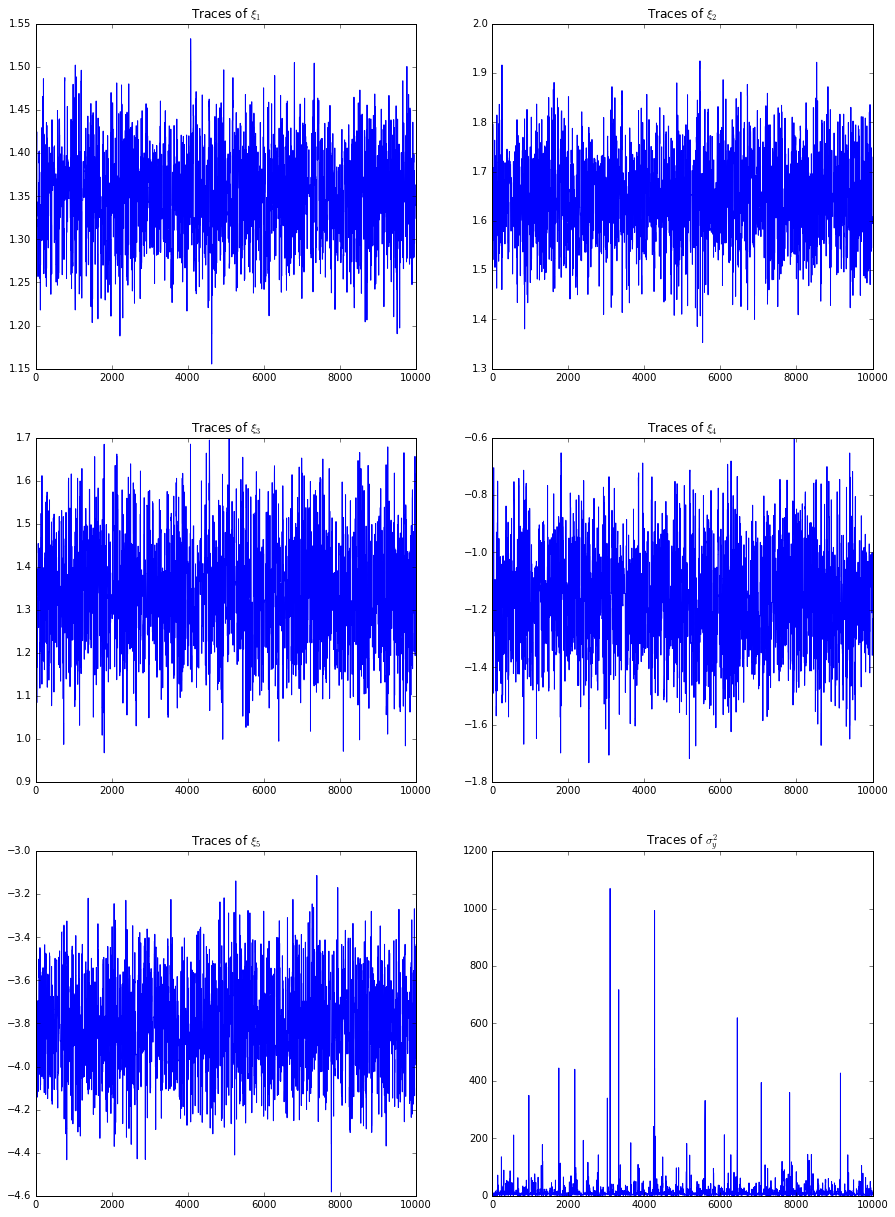

In [8]:
# ========================
# Trace plots of the sample
# ========================

figsize(15, 21)
plt.subplot(321)
plt.plot(xi_1_sample)
plt.title("Traces of $\\xi_1$")
plt.subplot(322)
plt.plot(xi_2_sample)
plt.title("Traces of $\\xi_2$")
plt.subplot(323)
plt.plot(xi_3_sample)
plt.title("Traces of $\\xi_3$")
plt.subplot(324)
plt.plot(xi_4_sample)
plt.title("Traces of $\\xi_4$")
plt.subplot(325)
plt.plot(xi_5_sample)
plt.title("Traces of $\\xi_5$")
plt.subplot(326)
plt.plot(sigY2_sample)
plt.title("Traces of $\\sigma_y^2$")

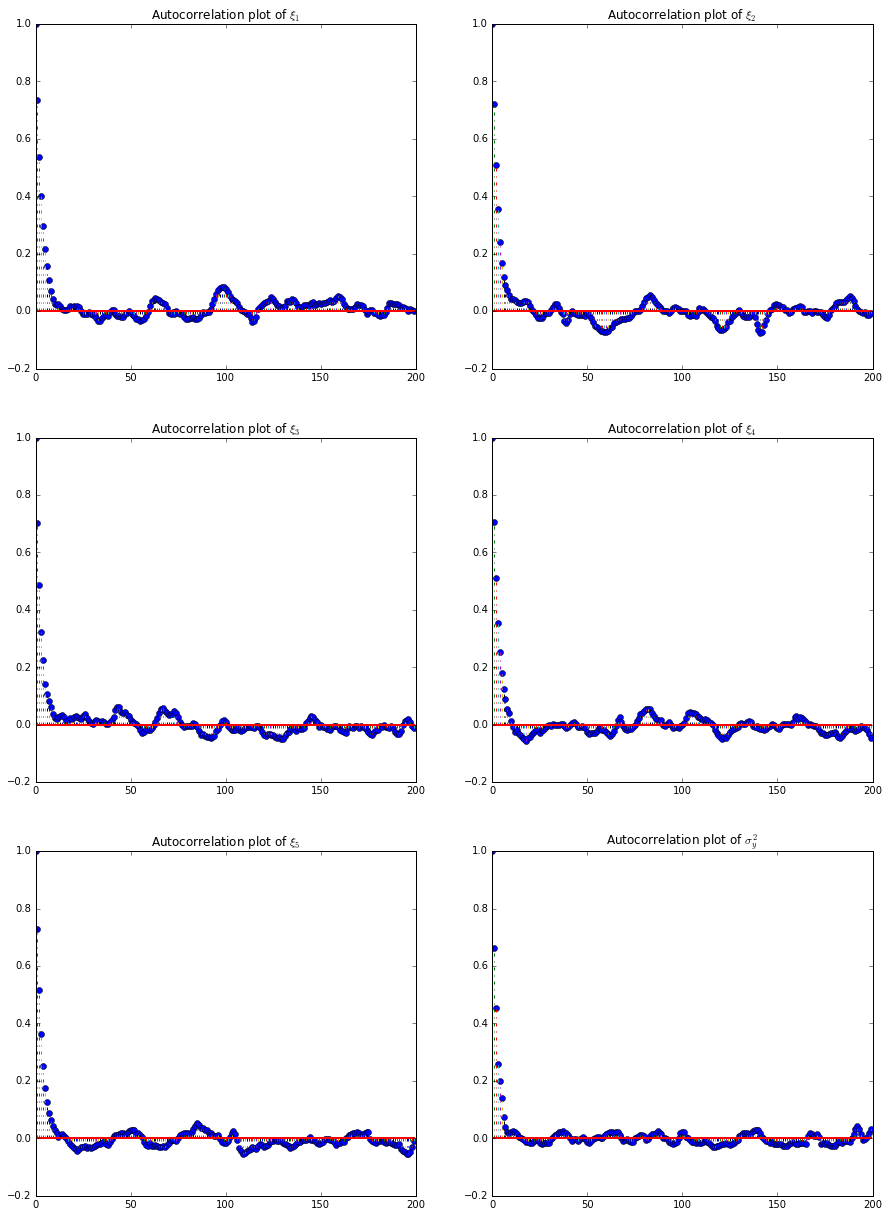

In [9]:
# ========================
# Autocorrelation plots
# ========================

ntail = 5000
klag = 200

figsize(15, 21)

plt.subplot(321)
xx = xi_1_sample[-ntail:]
yy = myacorr(xx)
markerline, stemlines, baseline = plt.stem( yy[:klag], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of $\\xi_1$")

plt.subplot(322)
xx = xi_2_sample[-ntail:]
yy = myacorr(xx)
markerline, stemlines, baseline = plt.stem( yy[:klag], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of $\\xi_2$")

plt.subplot(323)
xx = xi_3_sample[-ntail:]
yy = myacorr(xx)
markerline, stemlines, baseline = plt.stem( yy[:klag], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of $\\xi_3$")

plt.subplot(324)
xx = xi_4_sample[-ntail:]
yy = myacorr(xx)
markerline, stemlines, baseline = plt.stem( yy[:klag], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of $\\xi_4$")

plt.subplot(325)
xx = xi_5_sample[-ntail:]
yy = myacorr(xx)
markerline, stemlines, baseline = plt.stem( yy[:klag], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of $\\xi_5$")

plt.subplot(326)
xx = sigY2_sample[-ntail:]
yy = myacorr(xx)
markerline, stemlines, baseline = plt.stem( yy[:klag], '-.')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title("Autocorrelation plot of $\\sigma_y^2$")

In [10]:
# ================================================
# INFERENCE ON KAPPA ... SO WE DO A TRANSFORMATION
# ================================================

kappa_1_sample = np.exp(xi_1_sample)/180.0
kappa_2_sample = np.exp(xi_2_sample)/180.0
kappa_3_sample = np.exp(xi_3_sample)/180.0
kappa_4_sample = np.exp(xi_4_sample)/180.0
kappa_5_sample = np.exp(xi_5_sample)/180.0
#sigY2_sample = sigY2_sample

In [11]:
# ================================================
# Posterior expected values with standard errors
# ================================================

# POINT ESTIMATES OF UNKNOWN PRAMETERS

xx = kappa_1_sample.copy()
kappa_1_est = np.mean(xx)
kappa_1_se = np.sqrt(np.var(xx)*iat(xx)[0])/xx.size

xx = kappa_2_sample.copy()
kappa_2_est = np.mean(xx)
kappa_2_se = np.sqrt(np.var(xx)*iat(xx)[0])/xx.size

xx = kappa_3_sample.copy()
kappa_3_est = np.mean(kappa_3_sample)
kappa_3_se = np.sqrt(np.var(xx)*iat(xx)[0])/xx.size

xx = kappa_4_sample.copy()
kappa_4_est = np.mean(xx)
kappa_4_se = np.sqrt(np.var(xx)*iat(xx)[0])/xx.size

xx = kappa_5_sample.copy()
kappa_5_est = np.mean(xx)
kappa_5_se = np.sqrt(np.var(xx)*iat(xx)[0])/xx.size

xx = sigY2_sample.copy()
sigY2_est = np.mean(xx)
sigY2_se = np.sqrt(np.var(xx)*iat(xx)[0])/xx.size

print 'Point estimate for k_1:', kappa_1_est 
print "Standard error for k_1:", kappa_1_se 
print " "
print 'Point estimate for k_2:', kappa_2_est 
print "Standard error for k_2:", kappa_2_se 
print " "
print 'Point estimate for k_3:', kappa_3_est 
print "Standard error for k_3:", kappa_3_se 
print " "
print 'Point estimate for k_4:', kappa_4_est 
print "Standard error for k_4:", kappa_4_se 
print " "
print 'Point estimate for k_5:', kappa_5_est 
print "Standard error for k_5:", kappa_5_se 
print " "
print 'Point estimate for sigma_y^2:', sigY2_est 
print "Standard error for sigma_y^2:", sigY2_se 

Point estimate for k_1: 0.0214863284037
Standard error for k_1: 2.9213373949e-05
 
Point estimate for k_2: 0.0289643535956
Standard error for k_2: 5.93714601972e-05
 
Point estimate for k_3: 0.0213050622036
Standard error for k_3: 5.97432535835e-05
 
Point estimate for k_4: 0.00175502887378
Standard error for k_4: 6.89170889869e-06
 
Point estimate for k_5: 0.000125727021985
Standard error for k_5: 6.28239565354e-07
 
Point estimate for sigma_y^2: 13.3062888304
Standard error for sigma_y^2: 0.774848428224


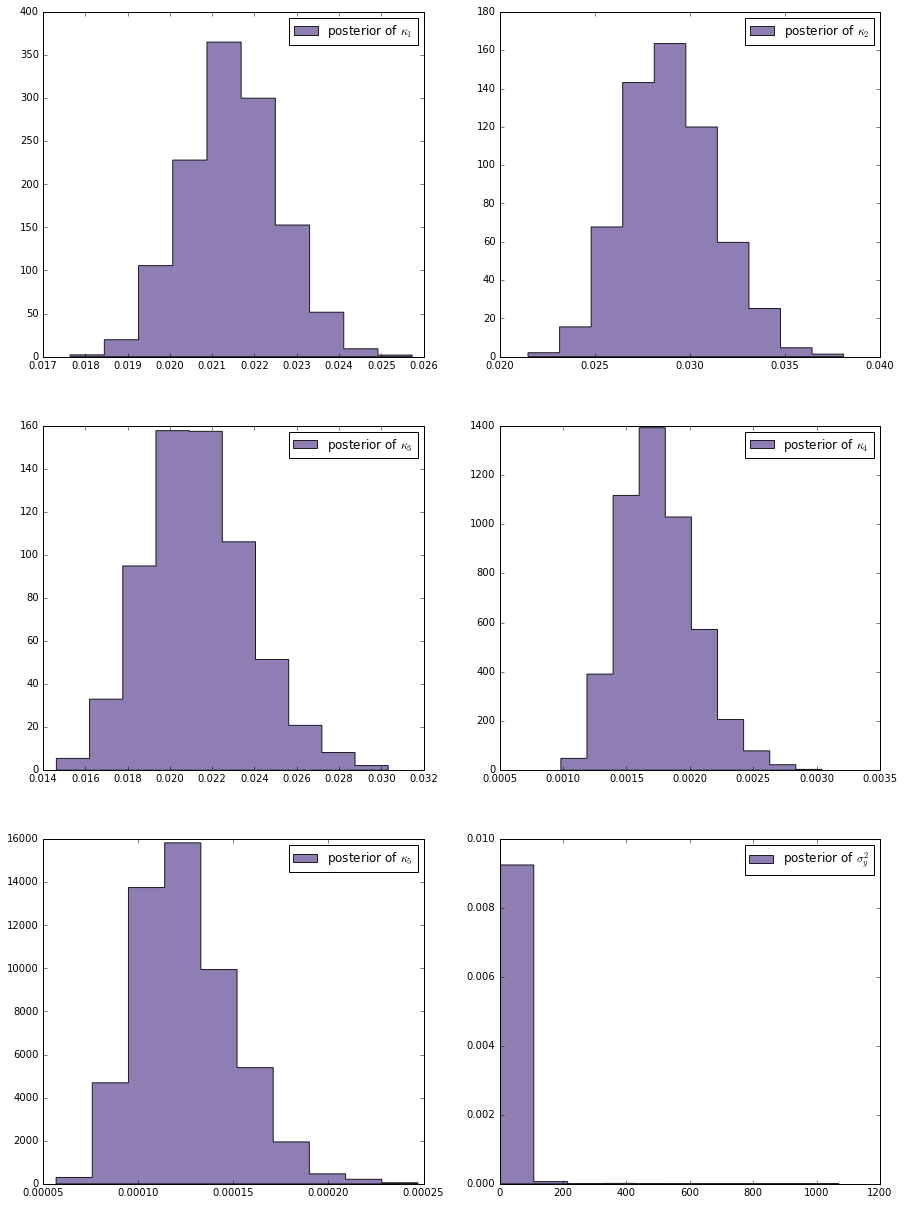

In [12]:
# ================================================
# Marginal posterior densities (Part 1, histograms only)
# ================================================

# PLOT THE MARGINAL POSTERIOR DENSITY 
figsize(15, 21)
plt.subplot(321)
plt.hist(kappa_1_sample, histtype='stepfilled', bins=10, alpha=0.85, label=r"posterior of $\kappa_1$", color="#7A68A6", normed=True); 
plt.legend()
plt.subplot(322)
plt.hist(kappa_2_sample, histtype='stepfilled', bins=10, alpha=0.85, label=r"posterior of $\kappa_2$", color="#7A68A6", normed=True); 
plt.legend()
plt.subplot(323)
plt.hist(kappa_3_sample, histtype='stepfilled', bins=10, alpha=0.85, label=r"posterior of $\kappa_3$", color="#7A68A6", normed=True); 
plt.legend()
plt.subplot(324)
plt.hist(kappa_4_sample, histtype='stepfilled', bins=10, alpha=0.85, label=r"posterior of $\kappa_4$", color="#7A68A6", normed=True); 
plt.legend()
plt.subplot(325)
plt.hist(kappa_5_sample, histtype='stepfilled', bins=10, alpha=0.85, label=r"posterior of $\kappa_5$", color="#7A68A6", normed=True); 
plt.legend()
plt.subplot(326)
plt.hist(sigY2_sample, histtype='stepfilled', bins=10, alpha=0.85, label=r"posterior of $\sigma_y^2$", color="#7A68A6", normed=True); 
plt.legend()
plt.show();


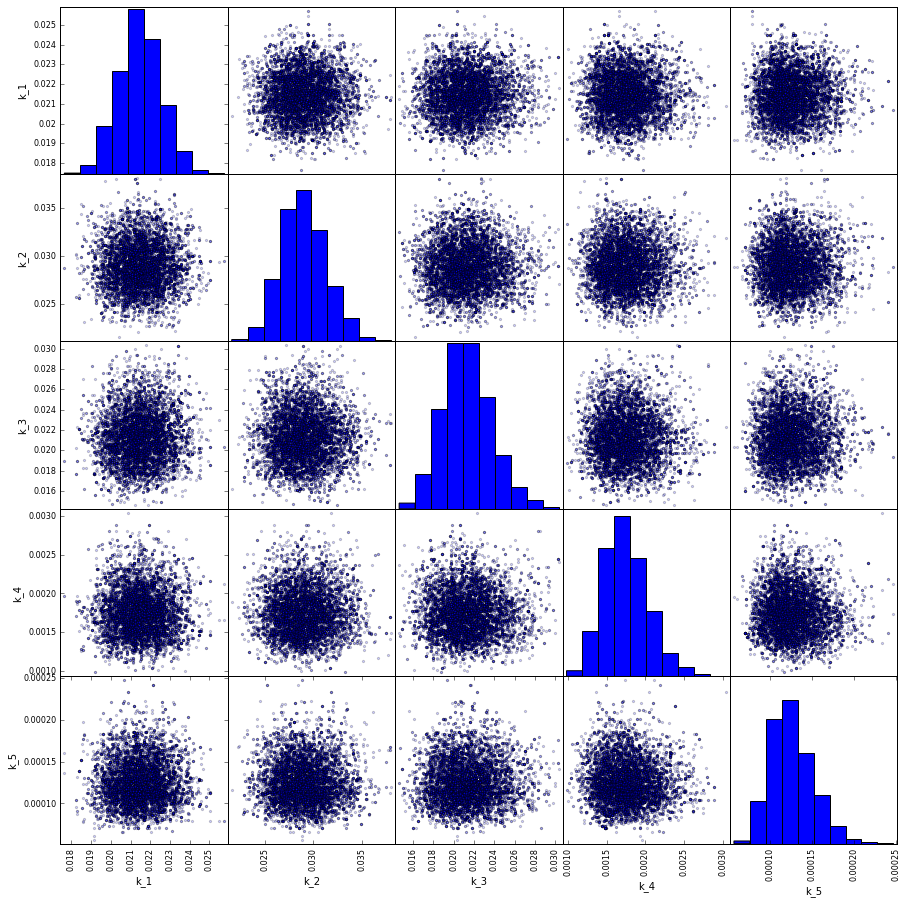

In [13]:
# ================================================
# Marginal posterior densities (Part 2, and pairwise scaterplots)
# ================================================

mat = np.array([kappa_1_sample, kappa_2_sample, kappa_3_sample, kappa_4_sample, kappa_5_sample]).T

from pandas.tools.plotting import scatter_matrix
from pandas import DataFrame
df = DataFrame(data=mat, columns=['k_1', 'k_2', 'k_3', 'k_4', 'k_5']) ;
scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='hist') ;